## data processing: i dati vanno interpolati su una griglia comune, evenutalmente inserendo zero-padding, e mandando a zero i primi e gli ultimi pochi canali, che sono solo noise.


#### metodo per il regridding

In [1]:
import h5py
import numpy as np

class SpectrumContainer:
    def __init__(self):
        self.spectra = []
        self.wavelengths = None

    def add_spectrum(self, spectrum):
        self.spectra.append(spectrum)

def reproject_spectra(file_path, group_name, lambda_range, lambda_bin, channels_out = 10):
    with h5py.File(file_path, 'r') as file:
        spectra_group = file[group_name]
        spectra_keys = list(spectra_group.keys())
        
        # Definisce la griglia comune di lunghezza d'onda basata su lambda_range e lambda_bin
        common_wavelength_grid = np.arange(lambda_range[0], lambda_range[1], lambda_bin)

        container = SpectrumContainer()
        container.wavelengths = common_wavelength_grid

        for spectrum_name in spectra_keys:
            spectrum_data = spectra_group[spectrum_name][:]
            wavelength_data = spectrum_data[0]  # Prima riga per lunghezze d'onda
            flux_data = spectrum_data[1]        # Seconda riga per il flusso

            flux_data[:channels_out] = 0                  # Imposta a zero i primi 10 canali
            flux_data[-channels_out:] = 0                 # Imposta a zero gli ultimi 10 canali

            # Interpolazione dello spettro sulla griglia comune
            interpolated_flux = np.interp(common_wavelength_grid, wavelength_data, flux_data, left=0, right=0)
            container.add_spectrum(interpolated_flux)

    return container

# funzioni per caricare e riproiettare gli spettri
def load_spectra(star_path, quasar_path, lambda_range, lambda_bin, channels_out = 10):
    stars = reproject_spectra(star_path, 'star_spectra', lambda_range, lambda_bin, channels_out)
    quasars = reproject_spectra(quasar_path, 'spectra', lambda_range, lambda_bin, channels_out)
    return stars, quasars


#### regridding 

##### NB: questa operazione e' di fatto inutile a questo livello, perche' interpoliamo spettri di stelle che poi rigetteremo dopo la selezione in flusso. Pero' l'operazione impiega solo poche decine di secondi e quindi preferisco farla prima per coerenza, in modo che posso fare una visualizzazione omogenea, ed anche avere piu' consistenza nel modo in cui estraggo il flusso per fare la selezione in seguito.


In [2]:
# operazione di regredding
lambda_range = (3.5, 4.1)  # range di lunghezza d'onda desiderato (scala logaritmica Angstrom)
lambda_bin = 1e-4              # bin desiderato (in log Angstrom) per gli spectra interpolati

# operazione di cut
channels_out = 20

# file path
star_path = 'Star_ML.h5'
quasar_path = 'Quasar_ML_50k.h5'

# caricamento spettri e riproiezione su griglia comune di lunghezza d'onda, con cut dei canali esterni
stars, quasars = load_spectra(star_path, quasar_path, lambda_range, lambda_bin, channels_out)

# data access
print("Numero di spettri di stelle:", len(stars.spectra))
print("Numero di spettri di quasar:", len(quasars.spectra))
print("Griglia di lunghezza d'onda comune:", stars.wavelengths)

Numero di spettri di stelle: 2505
Numero di spettri di quasar: 49375
Griglia di lunghezza d'onda comune: [3.5    3.5001 3.5002 ... 4.0997 4.0998 4.0999]


#### visualizzazione dei dati

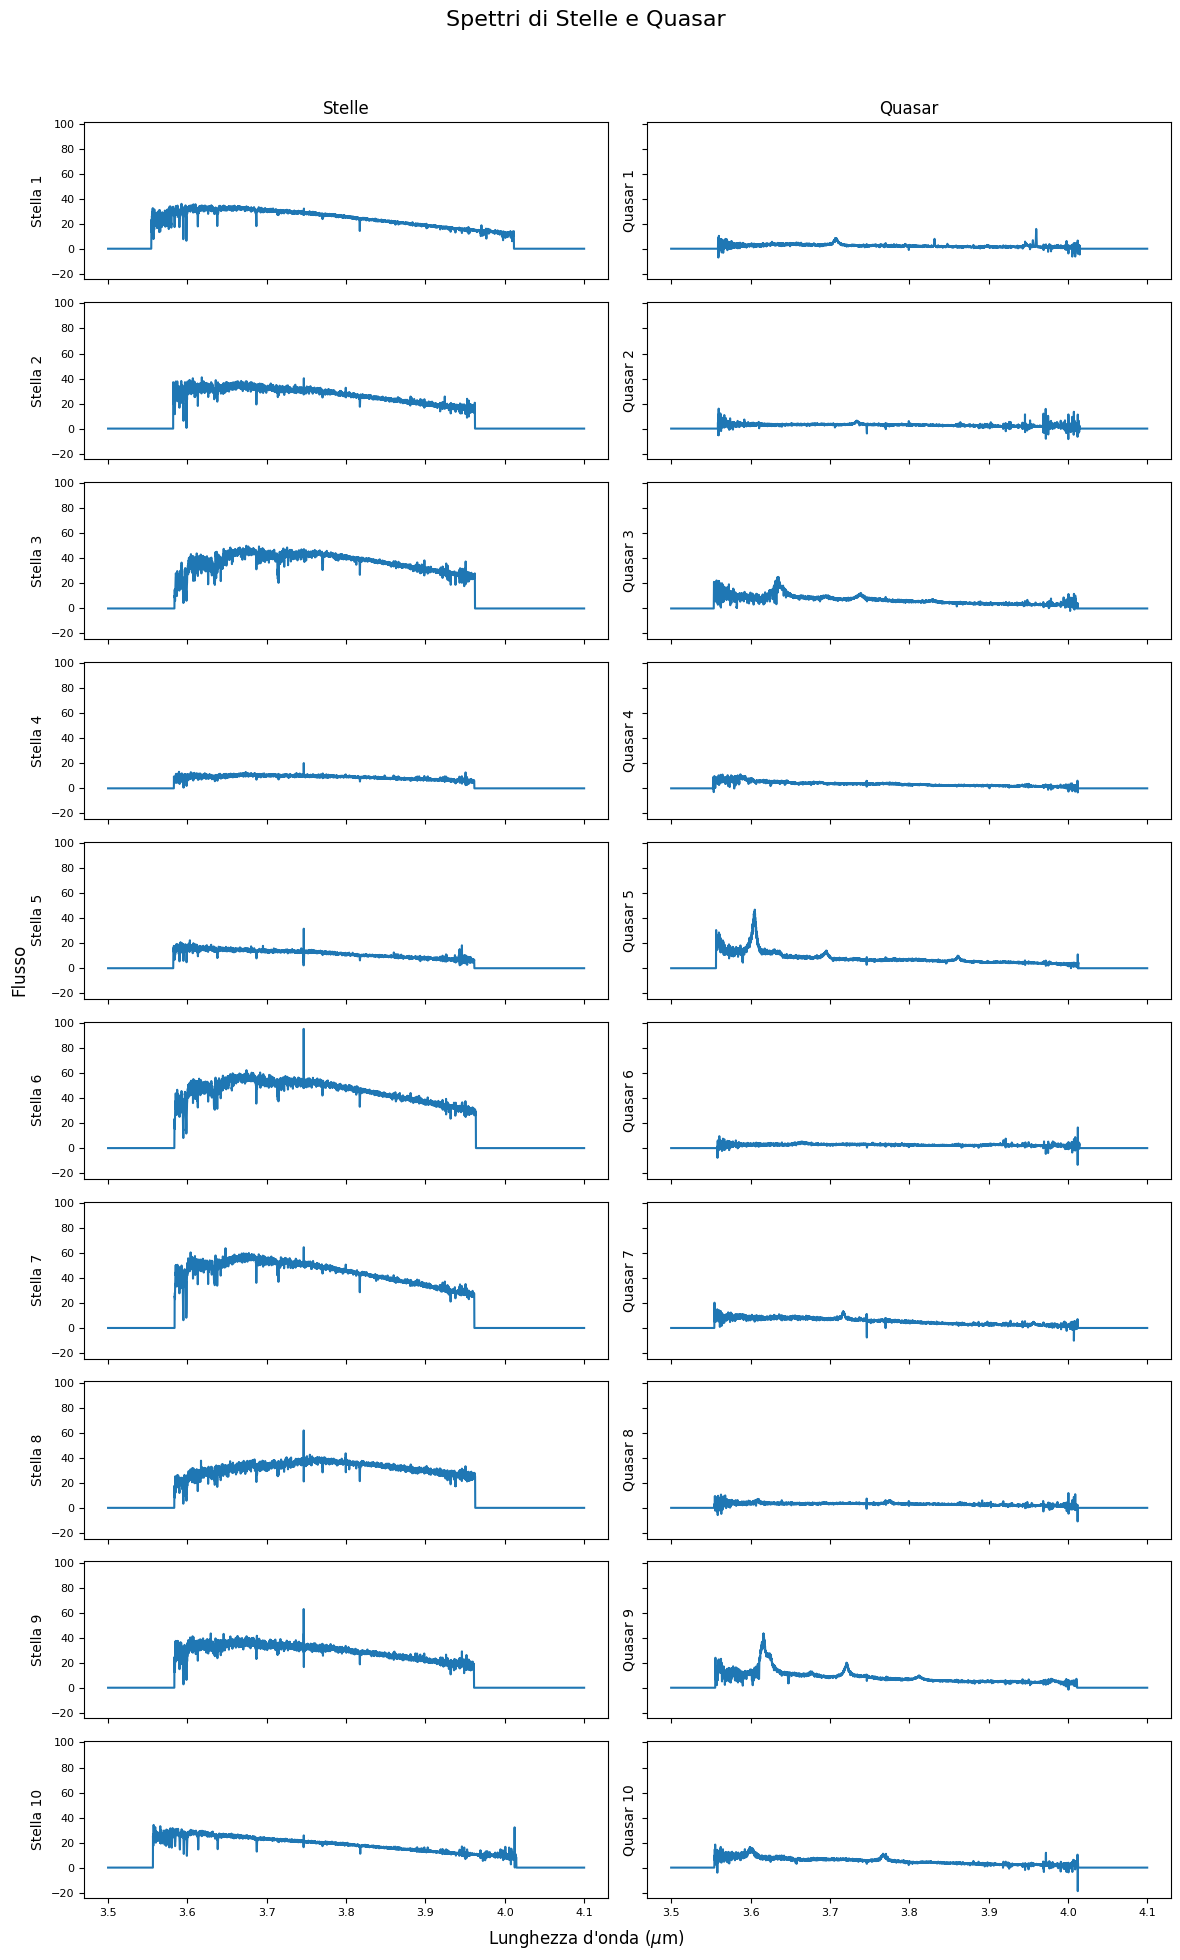

In [4]:
import matplotlib.pyplot as plt
import random

# Numero di spettri da visualizzare
num_spectra_to_show = 10

# Seleziona 10 indici casuali per le stelle e i quasar
star_indices = random.sample(range(len(stars.spectra)), num_spectra_to_show)
quasar_indices = random.sample(range(len(quasars.spectra)), num_spectra_to_show)

# plot stuff
fig, axs = plt.subplots(num_spectra_to_show, 2, figsize=(12, 20), sharex=True, sharey=True)
fig.suptitle("Spettri di Stelle e Quasar", fontsize=16)

# Stelle nella prima colonna
for i, idx in enumerate(star_indices):
    axs[i, 0].plot(stars.wavelengths, stars.spectra[idx])
    axs[i, 0].set_ylabel(f"Stella {i+1}")
    axs[i, 0].tick_params(axis='y', labelsize=8)
    axs[i, 0].tick_params(axis='x', labelsize=8)
    
# Visualizzazione dei quasar nella seconda colonna
for i, idx in enumerate(quasar_indices):
    axs[i, 1].plot(quasars.wavelengths, quasars.spectra[idx])
    axs[i, 1].set_ylabel(f"Quasar {i+1}")
    axs[i, 1].tick_params(axis='y', labelsize=8)
    axs[i, 1].tick_params(axis='x', labelsize=8)


axs[0, 0].set_title("Stelle", fontsize=12)
axs[0, 1].set_title("Quasar", fontsize=12)


fig.supxlabel(r"Lunghezza d'onda ($\mu$m)", fontsize=12)
fig.supylabel("Flusso", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Aggiusta il layout
plt.show()


### misuro flusso degli oggetti -- statistiche

In [5]:
from scipy.signal import medfilt

# Funzione per filtrare e integrare i flussi solo sui canali selezionati
def measure_flux_filtered(spectra_container, lambda_range):
    fluxes = []
    for spectrum in spectra_container.spectra:
        # Seleziona i canali all'interno dell'intervallo specificato
        mask = (spectra_container.wavelengths >= lambda_range[0]) & (spectra_container.wavelengths <= lambda_range[1])
        selected_flux = spectrum[mask]
        # selected_wavelengths = spectra_container.wavelengths[mask]

        # Applica il filtro mediano solo ai canali selezionati
        # filtered_flux = medfilt(selected_flux, kernel_size=5)  # kernel_size regolabile

        # Calcola il flusso di riferimento come media dei canali selezionati (si puo' fare diversamente)
        flux = np.median(selected_flux)
        fluxes.append(flux)

    return fluxes

# Intervallo di lunghezza d'onda specificato per il calcolo del flussso
lambda_range = (3.7, 3.8)

# Misura i flussi per stelle e quasars
star_fluxes = measure_flux_filtered(stars, lambda_range)
quasar_fluxes = measure_flux_filtered(quasars, lambda_range)

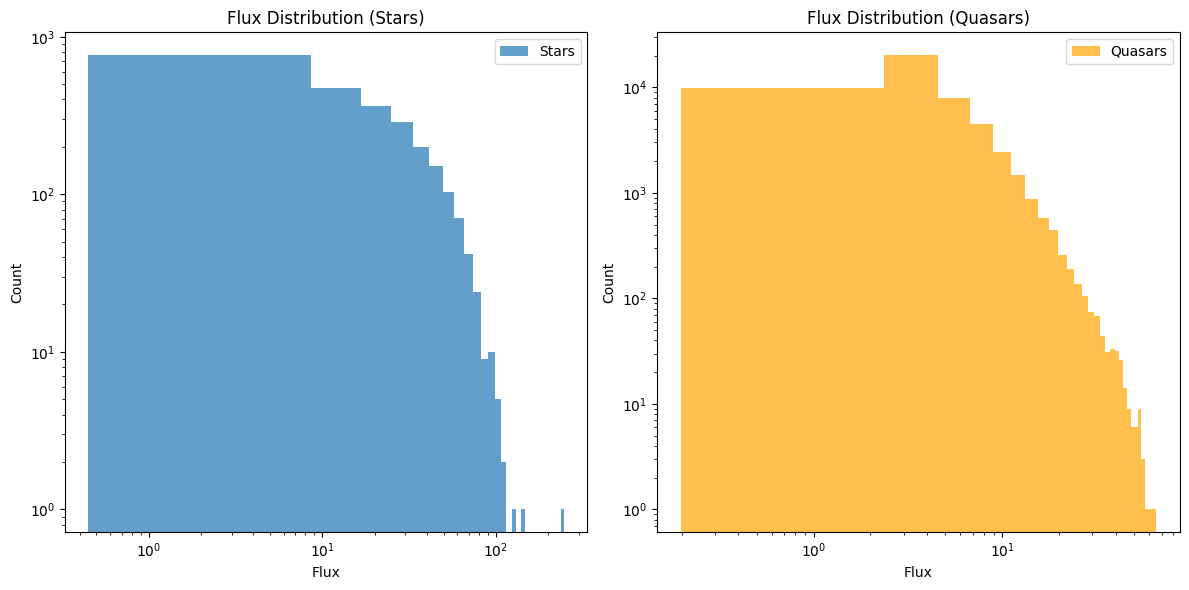

In [6]:

# Visualizza gli istogrammi delle distribuzioni
plt.figure(figsize=(12, 6))

# Istogramma per le stelle
plt.subplot(1, 2, 1)
plt.hist(star_fluxes, bins=30, alpha=0.7, label='Stars')
plt.xlabel('Flux')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.title('Flux Distribution (Stars)')
plt.legend()

# Istogramma per i quasars
plt.subplot(1, 2, 2)
plt.hist(quasar_fluxes, bins=30, alpha=0.7, label='Quasars', color='orange')
plt.xlabel('Flux')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.title('Flux Distribution (Quasars)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
np.min(star_fluxes), np.min(quasar_fluxes)


(0.44872399320285117, 0.19802759995089542)

### selezioniamo solo le stelle brillanti

In [8]:
class SpectrumContainer:
    def __init__(self):
        self.spectra = []
        self.wavelengths = None

    def add_spectrum(self, spectrum):
        self.spectra.append(spectrum)

def filter_spectra_by_flux(spectra_container, fluxes, threshold):
    # Crea un nuovo container per gli spettri selezionati
    selected_container = SpectrumContainer()
    selected_container.wavelengths = spectra_container.wavelengths

    # Nuovo array per i flussi selezionati
    selected_fluxes = []

    # Aggiungi solo gli spettri e i flussi che soddisfano il criterio
    for spectrum, flux in zip(spectra_container.spectra, fluxes):
        if flux > threshold:
            selected_container.add_spectrum(spectrum)
            selected_fluxes.append(flux)

    return selected_container, selected_fluxes

# Applica il filtro per selezionare le stelle con un certo flusso
flux_threshold = 20
selected_star, selected_star_fluxes = filter_spectra_by_flux(stars, star_fluxes, flux_threshold)

# checl del numero di stelle selezionate
print("Numero di stelle selezionate:", len(selected_star.spectra))
print("Numero di flussi selezionati:", len(selected_star_fluxes))


Numero di stelle selezionate: 1130
Numero di flussi selezionati: 1130


(6000,)

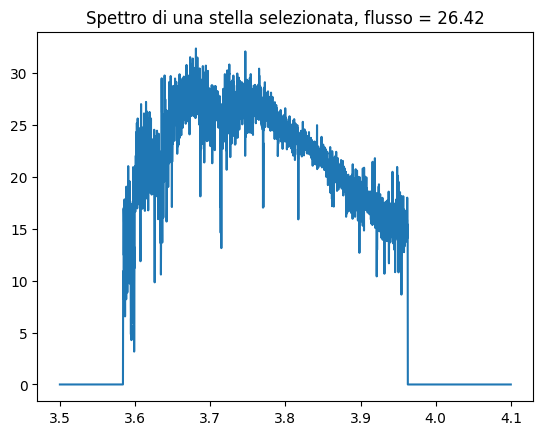

In [60]:
# Visualizza uno spettro selezionato per le stelle con flusso superiore alla soglia specificata, e il flusso corrispondente per riferimento
plt.plot(selected_star.wavelengths, selected_star.spectra[0])
plt.title("Spettro di una stella selezionata, flusso = {:.2f}".format(selected_star_fluxes[0]))

selected_star.spectra[0].shape

## Mixing degli spettri

#### questa funzione, data una lista di spettri di stelle e quasar, estrae un numero specifico di spettri da ciascuna categoria ed aggiunge una combinazione casuale di stelle e quasar.
#### La divisione e' un terzo quasar singoli, due terzi di combinazioni di stelle e quasar. Questo si puo' cambiare se necessario...

In [10]:
import random

# Funzione per creare spettri per la pipeline (quasar singoli e misti)
def create_pipeline_spectra(selected_stars, quasars, selected_star_fluxes, quasar_fluxes, num_spectra, 
                               min_star_flux_absolute, max_mixing_coefficient=1.0):
    
    """
Crea una pipeline di spettri composta da spettri di quasar singoli e misti (quasar + stelle). 
La funzione consente di controllare la combinazione di flussi e la loro distribuzione mediante parametri configurabili.

Parametri:
----------
selected_stars : SpectrumContainer
    Contiene gli spettri delle stelle selezionate e già filtrate in base a criteri di flusso.
quasars : SpectrumContainer
    Contiene gli spettri dei quasar disponibili per la combinazione.
selected_star_fluxes : list of float
    Lista dei flussi pre-calcolati per gli spettri delle stelle selezionate. Deve essere allineata a `selected_stars`.
quasar_fluxes : list of float
    Lista dei flussi pre-calcolati per gli spettri dei quasar. Deve essere allineata a `quasars`.
num_spectra : int
    Numero totale di spettri che si vuole generare nella pipeline. Circa un terzo di questi saranno quasar singoli, 
    mentre i restanti saranno spettri misti.
min_star_flux_absolute : float
    Valore minimo assoluto per il flusso delle stelle nel caso di spettri misti. 
    Controlla la componente stellare più bassa che può essere aggiunta ai quasar (default: 0.1).
max_mixing_coefficient : float, opzionale
    Coefficiente massimo per il mixing, che determina la frazione del flusso del quasar che può essere rappresentata 
    dal flusso della stella (default: 1.0).

Restituisce:
------------
pipeline_spectra : list of ndarray
    Lista contenente gli spettri risultanti. Ogni spettro può essere un quasar singolo o un misto (quasar + stella).
components_info : list of dict
    Informazioni sui componenti di ciascuno spettro nella pipeline. Ogni dizionario contiene:
        - 'spectrum': L'intero spettro generato (numpy array).
        - 'label': La classe dello spettro ('quasar' o 'mixed').
        - 'quasar': Lo spettro del quasar utilizzato (solo per gli spettri misti).
        - 'quasar_flux': Il flusso totale del quasar.
        - 'star': Lo spettro della stella (solo per gli spettri misti).
        - 'star_flux': Il flusso finale della stella dopo la normalizzazione e il mixing (solo per gli spettri misti).
        - 'flux_ratio': Il rapporto tra il flusso finale della stella e il flusso del quasar (solo per gli spettri misti).

Note:
-----
1. La funzione genera esattamente `num_spectra` spettri, di cui circa un terzo saranno quasar singoli.
2. Gli spettri misti sono generati combinando i quasar con stelle selezionate in base ai flussi configurabili.
3. Il flusso della stella in uno spettro misto è normalizzato a un valore minimo assoluto (`min_star_flux_absolute`) e 
   non supera mai una frazione del flusso del quasar, determinata da `max_mixing_coefficient`.

"""


    pipeline_spectra = []
    components_info = []

    # Calcola il numero di spettri per ciascuna categoria
    num_quasars = num_spectra // 3  # Un terzo quasar singoli
    num_mixed = num_spectra - num_quasars  # Due terzi misti

    # Aggiunge spettri di quasar
    for i in range(num_quasars):
        quasar_spectrum = quasars.spectra[i % len(quasars.spectra)]  # Garantisce la copertura di tutti i quasar
        quasar_flux = quasar_fluxes[i % len(quasar_fluxes)]  # Usa il flusso pre-calcolato
        pipeline_spectra.append(quasar_spectrum)
        components_info.append({
            "spectrum": quasar_spectrum,
            "label": "quasar",
            "quasar_flux": quasar_flux
        })

    # Aggiunge spettri misti
    for _ in range(num_mixed):
        # Seleziona un quasar e una stella casuali
        idx_quasar = random.randint(0, len(quasars.spectra) - 1)
        idx_star = random.randint(0, len(selected_stars.spectra) - 1)

        quasar_spectrum = quasars.spectra[idx_quasar]
        quasar_flux = quasar_fluxes[idx_quasar]

        star_spectrum = selected_stars.spectra[idx_star]
        star_flux = selected_star_fluxes[idx_star]

        # Randomly select a star flux between the minimum absolute value and the maximum allowed by the quasar flux
        final_star_flux = random.uniform(min_star_flux_absolute, quasar_flux * max_mixing_coefficient)

        # Normalizzazione dello spettro stellare
        normalized_star_spectrum = star_spectrum / star_flux  # Porta il flusso della stella a 1

        # Scaling dello spettro stellare in base al flusso finale
        scaled_star_spectrum = normalized_star_spectrum * final_star_flux

        flux_ratio = final_star_flux / quasar_flux

        # Combino quasar e stella
        mixed_spectrum = quasar_spectrum + scaled_star_spectrum

        # Salva lo spettro misto e le informazioni sulle componenti
        pipeline_spectra.append(mixed_spectrum)
        components_info.append({
            "spectrum": mixed_spectrum,
            "label": "mixed",
            "quasar": quasar_spectrum,
            "quasar_flux": quasar_flux,
            "star": scaled_star_spectrum,
            "star_flux": final_star_flux,  # Flux used in the mixing
            "flux_ratio": flux_ratio    # Ratio of the final star flux to the quasar flux
            })

    return pipeline_spectra, components_info



In [11]:
num_pipeline_spectra = 120000  # Numero totale di spettri nella pipeline

pipeline_spectra, components_info = create_pipeline_spectra(
    selected_star, quasars, selected_star_fluxes, quasar_fluxes, num_pipeline_spectra, 
    min_star_flux_absolute=0.45, max_mixing_coefficient=0.95
)


In [12]:
len(pipeline_spectra)
len(components_info)

120000

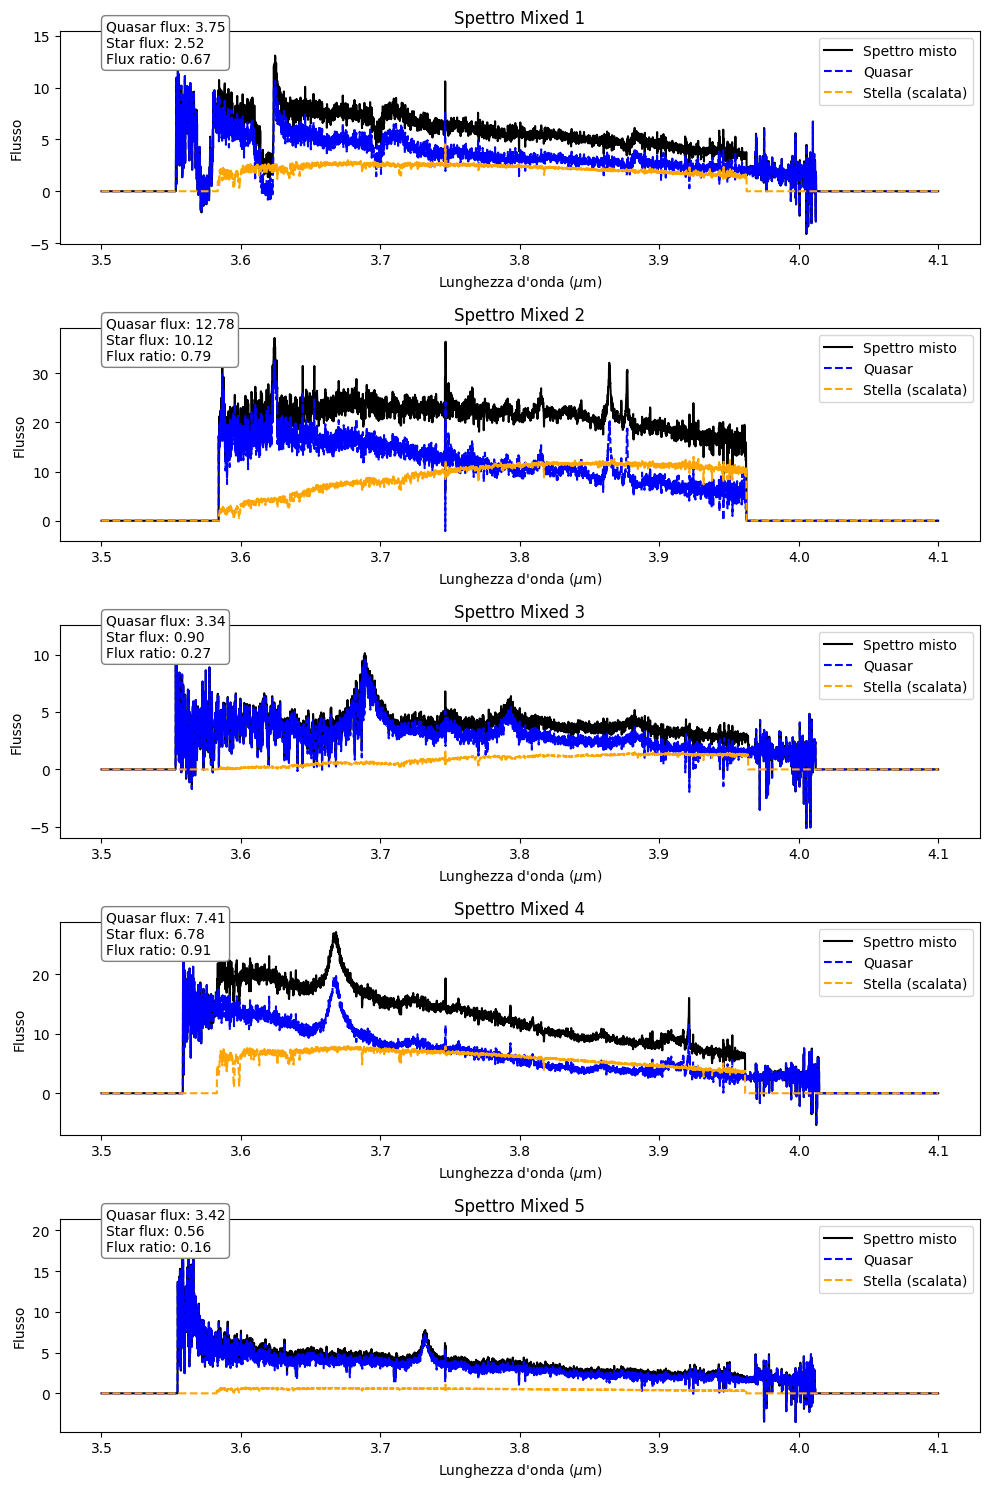

In [71]:
# Visualizzazione casuale di alcuni spettri dalla pipeline
num_plots = 5
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))

# Selezione casuale degli indici per la visualizzazione
indices = random.sample(range(len(pipeline_spectra)), num_plots)

for i, idx in enumerate(indices):
    if num_plots == 1:
        ax = axs
    else:
        ax = axs[i]
        
    # Dati dello spettro e delle componenti originali
    spectrum = pipeline_spectra[idx]
    label = components_info[idx]["label"]
    
    # Visualizzazione per ciascuna categoria
    if label == "mixed":
        quasar_spectrum = components_info[idx]["quasar"]
        star_spectrum = components_info[idx]["star"]
        quasar_flux = components_info[idx]["quasar_flux"]
        star_flux = components_info[idx]["star_flux"]
        flux_ratio = components_info[idx]["flux_ratio"]

        # Plot dello spettro misto e delle componenti
        ax.plot(selected_star.wavelengths, spectrum, label="Spettro misto", color="black")
        ax.plot(selected_star.wavelengths, quasar_spectrum, label="Quasar", linestyle="--", color="blue")
        ax.plot(selected_star.wavelengths, star_spectrum, label="Stella (scalata)", linestyle="--", color="orange")

        # Annotazioni per i flussi e il coefficiente di mixing
        ax.annotate(f"Quasar flux: {quasar_flux:.2f}\nStar flux: {star_flux:.2f}\nFlux ratio: {flux_ratio:.2f}", 
                    xy=(0.05, 0.85), xycoords="axes fraction", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white"))

    elif label == "star":
        # Plot dello spettro della stella
        ax.plot(selected_star.wavelengths, spectrum, label="Spettro di Stella", color="orange")
        
    elif label == "quasar":
        # Plot dello spettro del quasar
        ax.plot(selected_star.wavelengths, spectrum, label="Spettro di Quasar", color="blue")

    # Imposta titolo e annotazioni generali
    ax.set_title(f"Spettro {label.capitalize()} {i+1}")
    ax.set_xlabel(r"Lunghezza d'onda ($\mu$m)")
    ax.set_ylabel("Flusso")
    ax.legend()

plt.tight_layout()
plt.show()

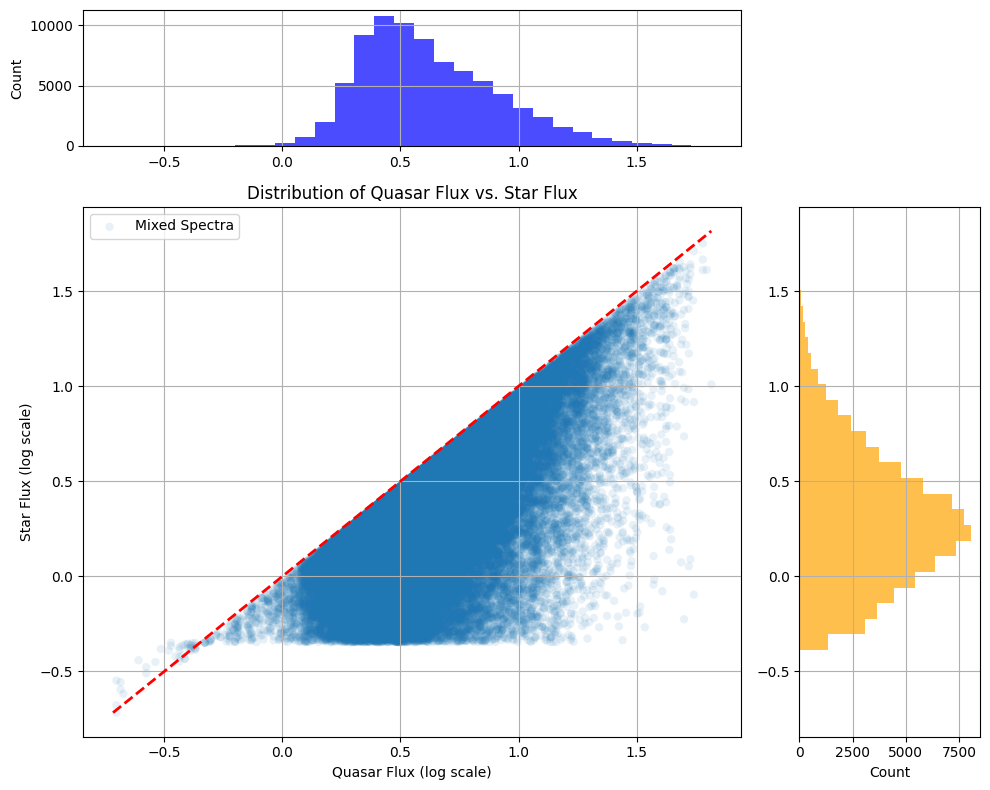

In [14]:
# visualizzazione della distribuzione di flusso quasar vs flusso stella

# Estrai i dati per il plot
quasar_fluxes_mixed = [info['quasar_flux'] for info in components_info if info['label'] == 'mixed']
star_fluxes_mixed = [info['star_flux'] for info in components_info if info['label'] == 'mixed']

# passo ai logaritmi per avere una visualizzazione migliore e piu in linea con la luminosita (o opposto della magnitudine if you want)
quasar_fluxes_mixed = np.log10(quasar_fluxes_mixed)
star_fluxes_mixed = np.log10(star_fluxes_mixed)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a grid for the main scatter plot and histograms
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_main.scatter(quasar_fluxes_mixed, star_fluxes_mixed, alpha=0.1, edgecolor='none', label='Mixed Spectra')
# ax_main.set_xscale('log')
# ax_main.set_yscale('log')
ax_main.set_xlabel('Quasar Flux (log scale)')
ax_main.set_ylabel('Star Flux (log scale)')
ax_main.set_title('Distribution of Quasar Flux vs. Star Flux')
ax_main.legend()
ax_main.grid(True)

# Add a 1-1 red dashed line
min_flux = min(min(quasar_fluxes_mixed), min(star_fluxes_mixed))
max_flux = max(max(quasar_fluxes_mixed), max(star_fluxes_mixed))
ax_main.plot([min_flux, max_flux], [min_flux, max_flux], 'r--', linewidth=2)

# Histogram for the x-axis (quasar fluxes)
ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_hist_x.hist(quasar_fluxes_mixed, bins=30, color='blue', alpha=0.7)
ax_hist_x.set_ylabel('Count')
ax_hist_x.grid(True)

# Histogram for the y-axis (star fluxes)
ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_hist_y.hist(star_fluxes_mixed, bins=30, color='orange', alpha=0.7, orientation='horizontal')
ax_hist_y.set_xlabel('Count')
ax_hist_y.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

#### preparazione dati per NN pipeline

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Carico gli spettri, le etichette e i metadati aggiuntivi
spectra = np.array(pipeline_spectra)  # Converte in array (per TensorFlow)
labels = np.array([info["label"] for info in components_info])
components_info_array = np.array(components_info)  # Trasforma in array per lo split

# Codifico le etichette come numeri (0: star, 1: quasar, 2: mixed)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dei dati in train/validation/test (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp, train_info, temp_info = train_test_split(
    spectra, encoded_labels, components_info_array, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test, val_info, test_info = train_test_split(
    X_temp, y_temp, temp_info, test_size=0.5, random_state=42
)



#### Modello di rete neurale convoluzionale (abbastanza semplice per iniziare)

In [16]:
import tensorflow as tf


# Modello CNN 
def create_cnn_classification_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        
        # Primo blocco conv + pooling
        tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        
        # Secondo blocco conv + pooling
        tf.keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        
        # Terzo blocco conv + pooling
        tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        
        # Flatten e strati densi finali
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')  # 3 output per le classi "star", "quasar", "mixed"
    ])
    
    # Compilazione del modello
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Creazione del modello CNN
input_shape = (spectra.shape[1], 1)  # Aggiunge un canale per Conv1D
model = create_cnn_classification_model(input_shape)


model.summary()


2024-12-09 11:11:08.685908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-09 11:11:11.641132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 11:11:11.641282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6000, 32)          256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1500, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1500, 64)          14400     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 375, 128)          57472     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 93, 128)          0

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Addestramento del modello
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=512, callbacks=[early_stopping])


Epoch 1/30


2024-12-09 11:11:35.908158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.7975

2024-12-09 11:12:20.299761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 47s 239ms/step - loss: 0.4354 - accuracy: 0.7975 - val_loss: 0.2899 - val_accuracy: 0.8736
Epoch 2/30
188/188 [==============================] - 42s 223ms/step - loss: 0.2628 - accuracy: 0.8911 - val_loss: 0.2316 - val_accuracy: 0.8985
Epoch 3/30
188/188 [==============================] - 42s 221ms/step - loss: 0.2046 - accuracy: 0.9187 - val_loss: 0.1835 - val_accuracy: 0.9292
Epoch 4/30
188/188 [==============================] - 42s 222ms/step - loss: 0.1659 - accuracy: 0.9359 - val_loss: 0.1595 - val_accuracy: 0.9383
Epoch 5/30
188/188 [==============================] - 42s 221ms/step - loss: 0.1365 - accuracy: 0.9468 - val_loss: 0.1645 - val_accuracy: 0.9322
Epoch 6/30
188/188 [==============================] - 42s 223ms/step - loss: 0.1210 - accuracy: 0.9526 - val_loss: 0.1245 - val_accuracy: 0.9510
Epoch 7/30
188/188 [==============================] - 42s 225ms/step - loss: 0.1096 - accuracy: 0.9585 - val_loss: 0.1175 - val_accuracy: 0.9

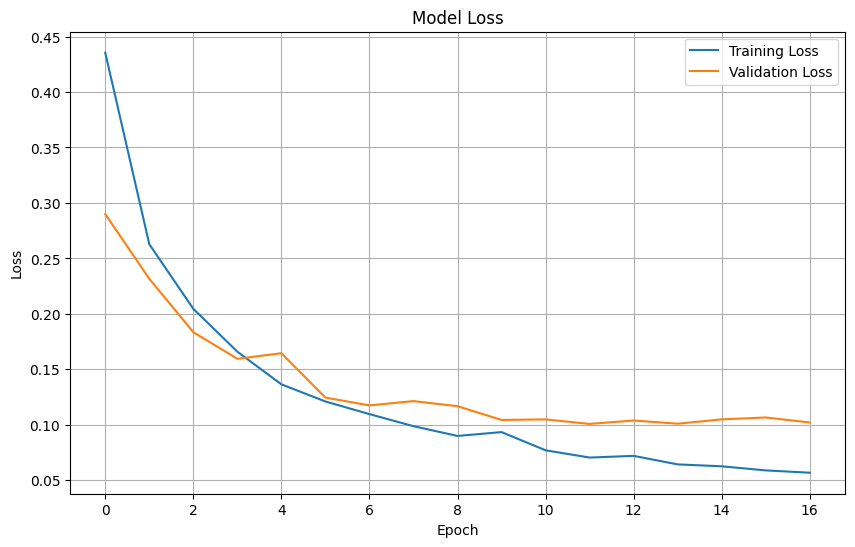

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [73]:
from tensorflow.keras.models import load_model

# Save the model
model.save('dual_classification_model_12Dec24.h5')

# Reload the model
reloaded_model = load_model('dual_classification_model_12Dec24.h5')

# Verify that the reloaded model works by evaluating it on the test set
reloaded_model.evaluate(X_test, y_test)

2024-12-12 09:07:19.769157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 5s 13ms/step - loss: 0.0957 - accuracy: 0.9623


[0.09568407386541367, 0.9623333215713501]

####  diagnostica globale sul test set: matrice di confusione per determinare l'accuratezza del modello sul set di test generale

  8/375 [..............................] - ETA: 2s  

2024-12-09 11:25:57.418820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 4s 10ms/step


<Figure size 800x600 with 0 Axes>

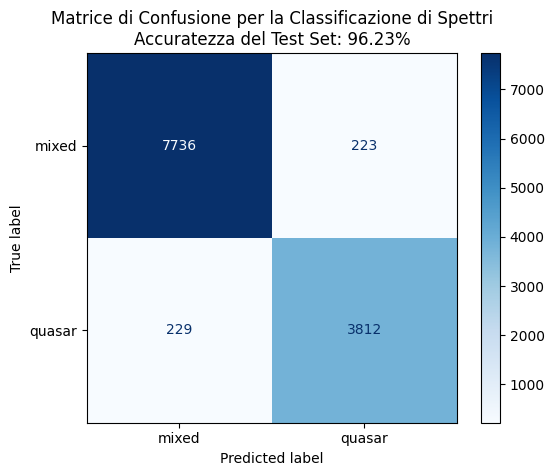

In [19]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizione sul set di test
y_pred = model.predict(X_test).argmax(axis=1)

# Calcolo della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
# Calcola l'accuratezza del test set
accuracy = np.mean(y_test == y_pred)

# Aggiungi l'accuratezza al titolo
plt.title(f"Matrice di Confusione per la Classificazione di Spettri\nAccuratezza del Test Set: {accuracy:.2%}")
plt.show()


#### # questo tipo di metrica e' piu' utile per capire come il modello si comporta su spettri misti. Non guardiamo piu' ad una accuracy generale, ma a come il modello si comporta su spettri misti al variare del flusso di quasar e stella e del rapporto tra i due.

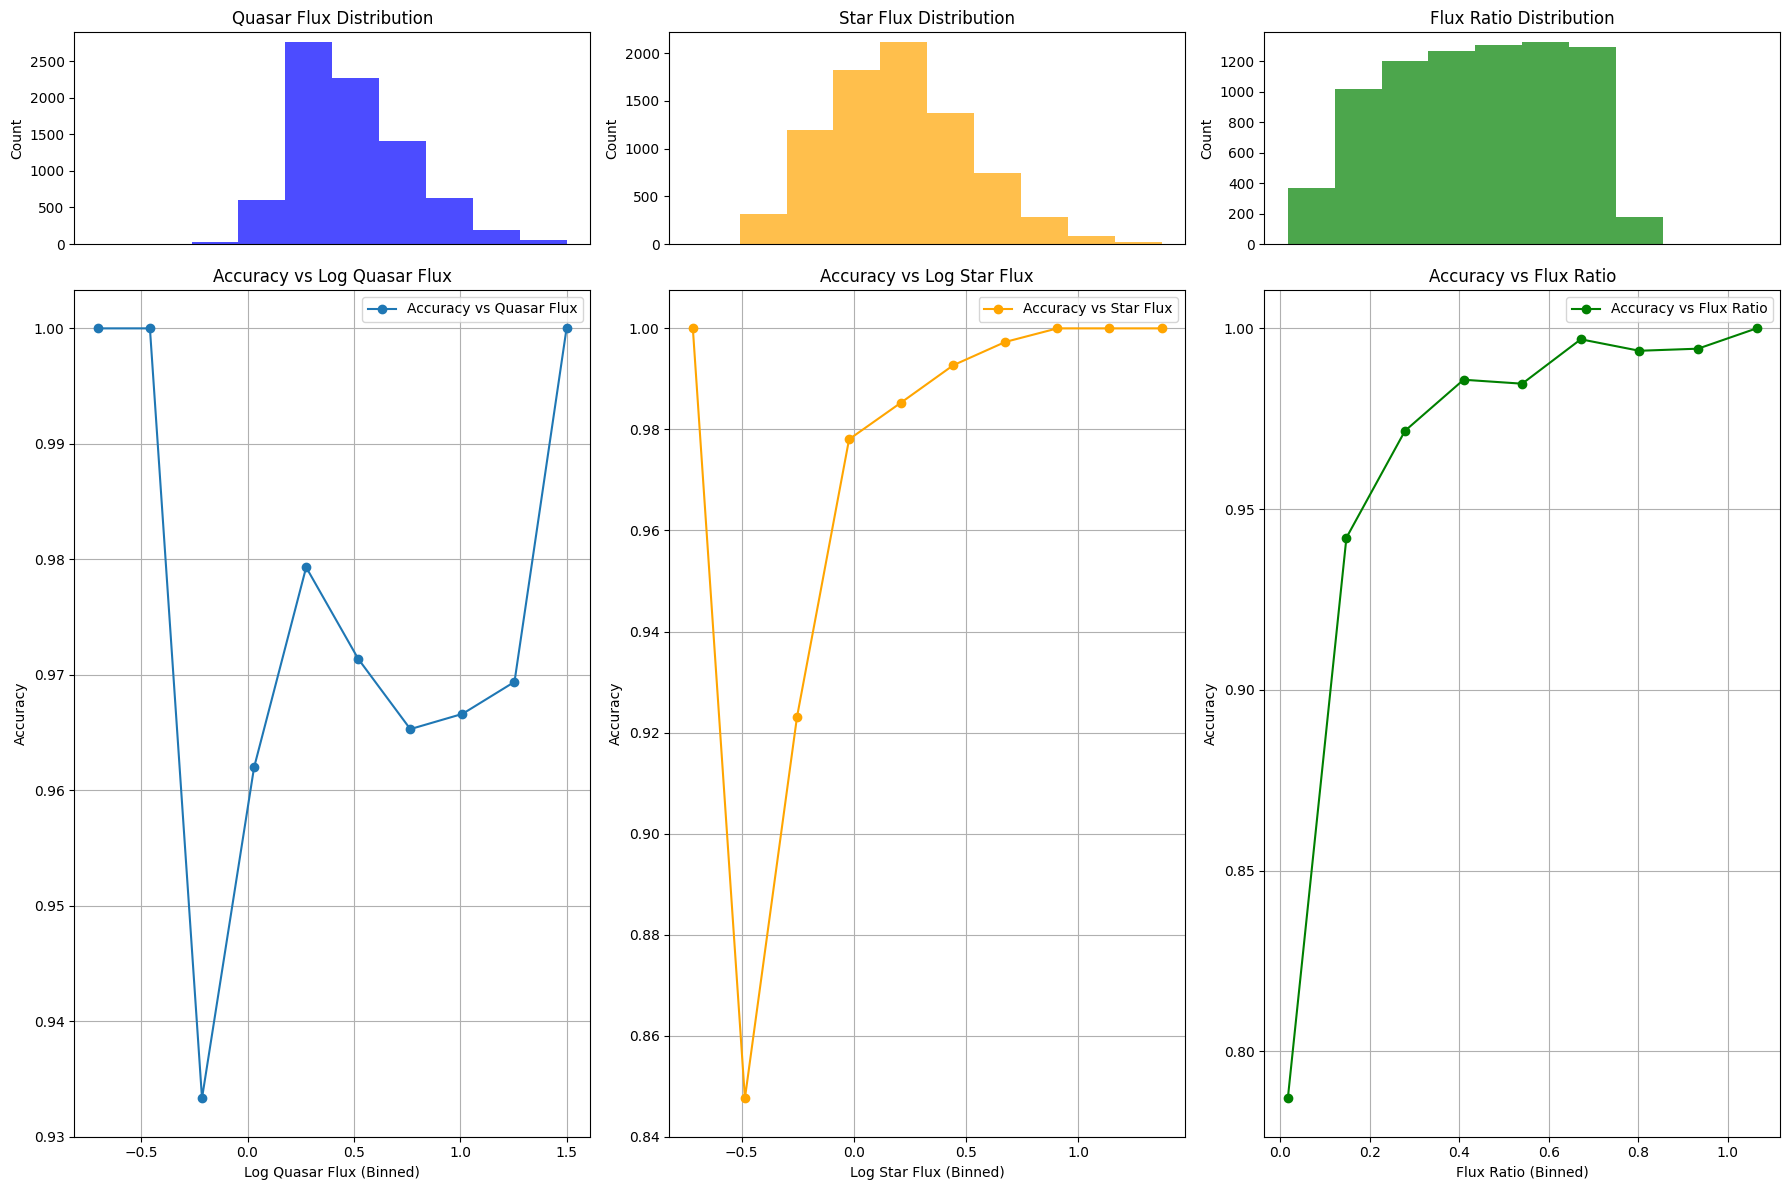

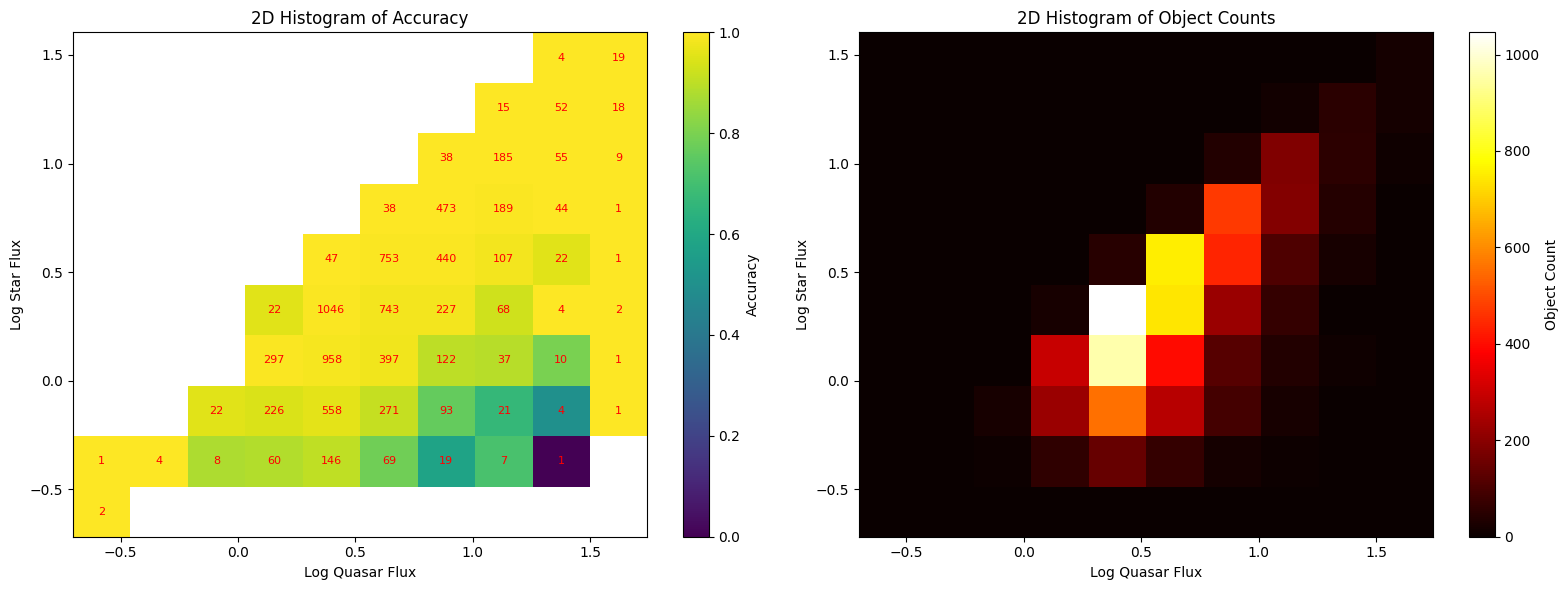

In [72]:
def analyze_mixed_spectra_flux_log(test_spectra, test_info, predictions, label_encoder, num_bins=5):
    """
    Analizza la classe "mixed" nel test set e genera grafici di accuratezza rispetto al
    flusso del quasar, al flusso della stella, al rapporto dei flussi e un istogramma 2D
    (flussi presi in scala logaritmica). Aggiunge istogrammi delle distribuzioni sopra i grafici.
    """
    # Trova l'indice della classe "mixed"
    mixed_label_index = label_encoder.transform(["mixed"])[0]

    # Filtra le informazioni per la classe "mixed"
    mixed_indices = [i for i, info in enumerate(test_info) if info["label"] == "mixed"]
    mixed_components_info = [test_info[i] for i in mixed_indices]

    # Estrai i flussi di quasar, stella e il rapporto tra i flussi
    quasar_fluxes = np.log10([info["quasar_flux"] for info in mixed_components_info])
    star_fluxes = np.log10([info["star_flux"] for info in mixed_components_info])
    flux_ratios = [info["flux_ratio"] for info in mixed_components_info]

    # Predizioni e ground truth per la classe "mixed"
    mixed_class_predictions = predictions[mixed_indices]
    ground_truth_labels = np.array([mixed_label_index] * len(mixed_indices))

    # Helper per calcolare accuratezze binned
    def calculate_binned_accuracy(bin_edges, values, true_labels, pred_labels):
        accuracies = []
        for i in range(len(bin_edges) - 1):
            mask = (values >= bin_edges[i]) & (values < bin_edges[i + 1])
            if np.sum(mask) > 0:
                accuracy = np.mean(pred_labels[mask] == true_labels[mask])
            else:
                accuracy = np.nan  # Per evitare bias nel calcolo
            accuracies.append(accuracy)
        return np.array(accuracies)

    # Calcola i bin per quasar_flux, star_flux e flux_ratio
    quasar_flux_bins = np.linspace(min(quasar_fluxes), max(quasar_fluxes), num_bins + 1)
    star_flux_bins = np.linspace(min(star_fluxes), max(star_fluxes), num_bins + 1)
    flux_ratio_bins = np.linspace(min(flux_ratios), max(flux_ratios), num_bins + 1)

    # Accuratezze binned
    quasar_flux_accuracy = calculate_binned_accuracy(quasar_flux_bins, quasar_fluxes, ground_truth_labels, mixed_class_predictions)
    star_flux_accuracy = calculate_binned_accuracy(star_flux_bins, star_fluxes, ground_truth_labels, mixed_class_predictions)
    flux_ratio_accuracy = calculate_binned_accuracy(flux_ratio_bins, flux_ratios, ground_truth_labels, mixed_class_predictions)

    # Accuratezze 2D (quasar_flux vs star_flux)
    bin_accuracies = np.zeros((num_bins, num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            mask = (
                (quasar_fluxes >= quasar_flux_bins[i]) & (quasar_fluxes < quasar_flux_bins[i + 1]) &
                (star_fluxes >= star_flux_bins[j]) & (star_fluxes < star_flux_bins[j + 1])
            )
            if np.sum(mask) > 0:
                bin_accuracies[i, j] = np.mean(mixed_class_predictions[mask] == ground_truth_labels[mask])
            else:
                bin_accuracies[i, j] = np.nan

    # Plot della distribuzione di accuratezza con istogrammi
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [1, 4]})

    # Istogramma della distribuzione dei flussi del quasar
    axs[0, 0].hist(quasar_fluxes, bins=quasar_flux_bins, color='blue', alpha=0.7)
    axs[0, 0].set_title("Quasar Flux Distribution")
    axs[0, 0].set_xticks([])
    axs[0, 0].set_ylabel("Count")

    # Accuratezza vs flusso del quasar
    axs[1, 0].plot(quasar_flux_bins[:-1], quasar_flux_accuracy, marker='o', label='Accuracy vs Quasar Flux')
    axs[1, 0].set_xlabel("Log Quasar Flux (Binned)")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title("Accuracy vs Log Quasar Flux")
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Istogramma della distribuzione dei flussi della stella
    axs[0, 1].hist(star_fluxes, bins=star_flux_bins, color='orange', alpha=0.7)
    axs[0, 1].set_title("Star Flux Distribution")
    axs[0, 1].set_xticks([])
    axs[0, 1].set_ylabel("Count")

    # Accuratezza vs flusso della stella
    axs[1, 1].plot(star_flux_bins[:-1], star_flux_accuracy, marker='o', label='Accuracy vs Star Flux', color='orange')
    axs[1, 1].set_xlabel("Log Star Flux (Binned)")
    axs[1, 1].set_ylabel("Accuracy")
    axs[1, 1].set_title("Accuracy vs Log Star Flux")
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Istogramma della distribuzione dei flux_ratio
    axs[0, 2].hist(flux_ratios, bins=flux_ratio_bins, color='green', alpha=0.7)
    axs[0, 2].set_title("Flux Ratio Distribution")
    axs[0, 2].set_xticks([])
    axs[0, 2].set_ylabel("Count")

    # Accuratezza vs flux_ratio
    axs[1, 2].plot(flux_ratio_bins[:-1], flux_ratio_accuracy, marker='o', label='Accuracy vs Flux Ratio', color='green')
    axs[1, 2].set_xlabel("Flux Ratio (Binned)")
    axs[1, 2].set_ylabel("Accuracy")
    axs[1, 2].set_title("Accuracy vs Flux Ratio")
    axs[1, 2].grid(True)
    axs[1, 2].legend()

    plt.tight_layout()
    plt.show()

    # # Plot separato per l'istogramma 2D
    # plt.figure(figsize=(8, 6))
    # plt.imshow(bin_accuracies.T, origin='lower', extent=[
    #     quasar_flux_bins[0], quasar_flux_bins[-1], star_flux_bins[0], star_flux_bins[-1]
    # ], aspect='auto', cmap='viridis', interpolation='nearest')
    # plt.colorbar(label='Accuracy')
    # plt.xlabel("Log Quasar Flux")
    # plt.ylabel("Log Star Flux")
    # plt.title("2D Histogram of Accuracy")
    # plt.tight_layout()
    # plt.show()

    # Calculate the counts per bin
    object_counts = np.zeros((num_bins, num_bins))
    for i in range(num_bins):
        for j in range(num_bins):
            mask = (
                (quasar_fluxes >= quasar_flux_bins[i]) & (quasar_fluxes < quasar_flux_bins[i + 1]) &
                (star_fluxes >= star_flux_bins[j]) & (star_fluxes < star_flux_bins[j + 1])
            )
            object_counts[i, j] = np.sum(mask)

    # Plot: 2D histogram of accuracy and object counts side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    im1 = axs[0].imshow(bin_accuracies.T, origin='lower', extent=[
        quasar_flux_bins[0], quasar_flux_bins[-1], star_flux_bins[0], star_flux_bins[-1]
    ], aspect='auto', cmap='viridis', interpolation='nearest')
        # Overlay the object counts
    for i in range(num_bins):
        for j in range(num_bins):
            count = int(object_counts[i, j])
            if count > 0:  # Only annotate non-empty bins
                axs[0].text(
                    quasar_flux_bins[i] + (quasar_flux_bins[1] - quasar_flux_bins[0]) / 2,
                    star_flux_bins[j] + (star_flux_bins[1] - star_flux_bins[0]) / 2,
                    f"{count}", ha='center', va='center', fontsize=8, color="red"
                )
    fig.colorbar(im1, ax=axs[0], label='Accuracy')
    axs[0].set_xlabel("Log Quasar Flux")
    axs[0].set_ylabel("Log Star Flux")
    axs[0].set_title("2D Histogram of Accuracy")

    

    # Object count plot
    im2 = axs[1].imshow(object_counts.T, origin='lower', extent=[
        quasar_flux_bins[0], quasar_flux_bins[-1], star_flux_bins[0], star_flux_bins[-1]
    ], aspect='auto', cmap='hot', interpolation='nearest')
    fig.colorbar(im2, ax=axs[1], label='Object Count')
    axs[1].set_xlabel("Log Quasar Flux")
    axs[1].set_ylabel("Log Star Flux")
    axs[1].set_title("2D Histogram of Object Counts")

    plt.tight_layout()
    plt.show()


# --------------------


# Call the function to analyze mixed spectra
analyze_mixed_spectra_flux_log(
    test_spectra=X_test,
    test_info=test_info,
    predictions=y_pred,
    label_encoder=label_encoder,
    num_bins=10
)



In [ ]:
# def plot_spectrum_with_saliency(model, test_spectra, test_info, label_encoder, wavelength_grid):
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import tensorflow as tf
#     from scipy.ndimage import gaussian_filter1d

#     # Seleziona uno spettro casuale dal test set
#     random_index = np.random.choice(len(test_spectra))
#     spectrum = test_spectra[random_index]
#     metadata = test_info[random_index]
    
#     # Estrai metadati e informazioni
#     ground_truth_label = metadata["label"]
#     flux_ratio = metadata.get("flux_ratio", None)

#     # Compute saliency map
#     spectrum_tensor = np.expand_dims(spectrum, axis=0)  # Add batch dimension
#     target_class = label_encoder.transform([ground_truth_label])[0]  # Classe target
#     with tf.GradientTape() as tape:
#         input_tensor = tf.convert_to_tensor(spectrum_tensor, dtype=tf.float32)
#         tape.watch(input_tensor)
#         predictions = model(input_tensor)
#         target_score = predictions[0][target_class]  # Seleziona il punteggio della classe target

#     saliency = tape.gradient(target_score, input_tensor)[0].numpy()
#         # Apply Gaussian smoothing to the saliency map
#     saliency_smoothed = gaussian_filter1d(saliency, sigma=1)
#     saliency_smoothed[(wavelength_grid<3.6) | (wavelength_grid>3.9)] = 0  # Mask the region of interest


#     # Plot spectrum and saliency
#     plt.figure(figsize=(10, 6))

#     # Spettro
#     plt.subplot(2, 1, 1)
#     plt.plot(wavelength_grid, spectrum, label="Spectrum")
#     # plt.title(
#     #     f"Type: {ground_truth_label} | "
#     #     f"Div Factor: {div_factor:.2f} | Mixing Coefficient: {mixing_coefficient:.2f}"
#     #     if div_factor is not None and mixing_coefficient is not None
#     #     else f"Type: {ground_truth_label}"
#     # )
#     plt.xlabel("Wavelength")
#     plt.ylabel("Flux")
#     plt.legend()

#     # Mappa di salienza
#     plt.subplot(2, 1, 2)
#     plt.plot(wavelength_grid, saliency_smoothed, label="Saliency Map", color="orange")
#     plt.xlabel("Wavelength")
#     plt.ylabel("Saliency")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()



# # let's go 

# # maschera booleana per identificare la classe "mixed"
# mixed_label = label_encoder.transform(["mixed"])[0]
# mask = np.array([info["label"] == "mixed" for info in test_info])

# # # Filtra gli spettri e i metadati usando la maschera
# # mixed_spectra = X_test[mask]
# # mixed_info = np.array(test_info)[mask]

# plot_spectrum_with_saliency(
#     model=model,
#     test_spectra=X_test[mask],
#     test_info=test_info[mask],
#     label_encoder=label_encoder,
#     wavelength_grid=stars.wavelengths
# )

